<html>
<head>
	<title></title>
</head>
<body>
<h2 style="text-align: center;line-height: 120%;">ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ «МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ»
Кафедра «РЗиАЭ»</h2>
<h2 style="text-align: center;line-height: 20%;">Лабораторная работа №2</h2>

<h3 style="text-align: center;line-height: 80%;"><em>НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР. МЕТОД
ОПОПРНЫХ ВЕКТОРОВ</em></h3>

<p style="text-align: right;line-height: 40%;">Выполнил: студент группы Э-13м-21</p>

<p style="text-align: right;line-height: 40%;">Груздов А.Г.</p>

<p style="text-align: right;line-height: 40%;">Проверил: Нухулов С.М., Малютин М.С.</p>
<h4 style="text-align: center;line-height: 100%;"><em> Москва, 2022</em></h3>
</body>
</html>

<h2>Целью работы</h2>

Является получение практических навыков работы с моделями байесовского классификатора и метода опорных векторов в программной среде Python.
<ol>
<li>Анализ, предварительную предобработку и визуализацию данных.</li>
<li>Обучение и применение наивного байесовского классификатора и модели опорных векторов с оптимальными параметрами.</li>
<li>Построение и визуализация матрицы ошибок и ROC-кривой для моделей с оптимальными выбранными параметрами, а также расчет метрики AUC-ROC.</li>
</ol>

<h3>Импорт библиотек</h3>

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from collections import Counter
from sklearn import feature_extraction

<h3> 1. Загрузка анализируемых данных csv </h3>

- Загрузим данные в формате «.csv» используем метод read_csv библиотеки Pandas, аргументом которого является путь к файлу.
Метод возвращает объект класса DataFrame.

In [104]:
data=pd.read_csv(r"K:\Project\Python\AI\source\spam.csv", encoding = 'latin1')
#Удаление ненужных столбцов
data=data.drop(columns=['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'])
data = data.rename(columns={'v1': 'target', 'v2': 'text'})
data.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h3> 2. Построить круговую диаграмму для принимаемых значений целевой переменной. </h3>

- Используем метод plot класса DataFrame, чтобы построить круговую диаграмму целевых значений:

Text(0.5, 1.0, 'Диаграмма целевой переменной')

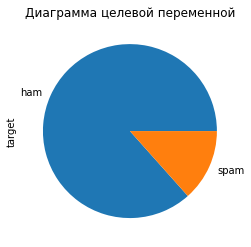

In [105]:
target = pd.value_counts(data['target']) #столбец целевой переменной в объекте класса DataFrame.
target.plot(kind = 'pie')
plt.title('Диаграмма целевой переменной')

<h3> 3. Построить столбиковую диаграмму для двадцати наиболее часто встречающихся слов в обоих классах.</h3>

- Прежде вычислим наиболее часто встречающиеся слова в обоих классах. Для этого воспользуемся классом collections.Counter и методом most_common:

<h4>3.1 Для случая слова "ham"</h4>

In [106]:
ham_words = Counter(" ".join(data[data['target']=='ham']["text"]).split()).most_common(20)
df_ham_words = pd.DataFrame.from_dict(ham_words)
df_ham_words = df_ham_words.rename(columns={0: "words of ham", 1 : "count"})

- Построим столбиковую диаграмму, воспользовавшись методом plot.bar класса DataFrame:

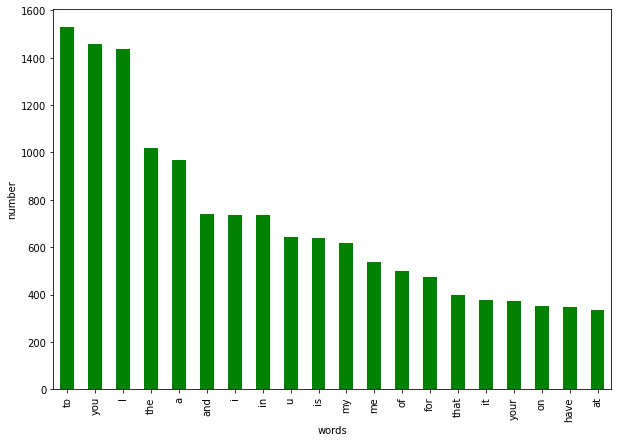

In [107]:
df_ham_words.plot.bar(legend = False, color = 'green',figsize = (10,7))
y_pos = np.arange(len(df_ham_words["words of ham"]))
plt.xticks(y_pos, df_ham_words["words of ham"])
plt.xlabel('words')
plt.ylabel('number')
plt.show()

<h4>3.2 Для случая слова "spam"</h4>

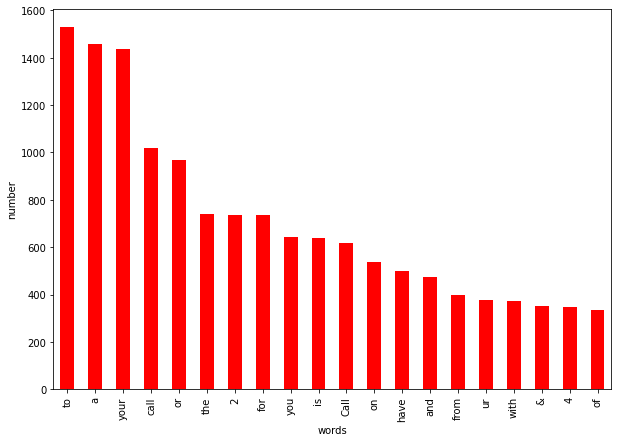

In [108]:
spam_words = Counter(" ".join(data[data['target']=='spam']['text']).split()).most_common(20)
df_spam_words = pd.DataFrame.from_dict(spam_words)
df_spam_words = df_spam_words.rename(columns={0: "words of spam", 1 : "count"})
df_ham_words.plot.bar(legend = False, color = 'red',figsize = (10,7))
y_pos = np.arange(len(df_spam_words["words of spam"]))
plt.xticks(y_pos, df_spam_words["words of spam"])
plt.xlabel('words')
plt.ylabel('number')
plt.show()

<h3>4. Выполнить токенизацию текстового признака, исключив неинформативные часто встречающиеся слова.</h3>

Текст — это набор токенов. Токенизация – это преобразование текста в признаковый вектор,отражающий информационное содержание письма. В данной задаче для
выполнения токенизации можно воспользоваться классом CountVectorizer библиотеки Scikit-learn

In [109]:
tokenizer = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = tokenizer.fit_transform(data['text'])

<h3> 5. Найти оптимальный параметр сглаживания alpha для наивного байесовского классификатора по метрикам precision и accuracy. </h3>

<img src="source/Формула Байеса.png" tyle="text-align: center;line-height: 100%;">

<ul>
<li>P(A|B) - вероятность, что слово В принадлежит к классу А(spam).</li>
<li>P(B|A) - вероятность встретить слово В в классе А(spam).</li>
<li>P(A) - вероятность встретить класс А среди всех текстов.</li>
<li>P(B) - вероятность встретить слово В среди всех текстов.</li>
</ul>

НБА предполагает, что наличие какого-либо признака в классе не связано с наличием какого-либо другого признака. Цель классификации - понять к какому классу принадлежит слово, поэтому нужна не сама вероятность, а наиболее вероятный класс.

<img src="https://imgur.com/dJqfWDv.png" tyle="text-align: center;line-height: 100%;">

вхождение слова Xi в документ класса Qk:

<img src="https://imgur.com/CfFpJlY.png" tyle="text-align: center;line-height: 100%;">

<ul>
<li>Nk - количество слов входящих в текст класса Qk.</li>
<li>M - количество слов из обучающей выборки</li>
<li>Nik - количество вхождений слова Xi в текст класса Qk</li>
<li>a-сглаживающий параметр (чтобы значения логарифмируемых вероятностей были не слишком близки к 0, например при незнакомых словах(нет в словаре) в тексте).</li>
</ul>

Multinomial (мультиномиальное распределение). Используется в случае дискретных признаков. Признаки могут показывать, сколько раз каждое слово встречается в данном тексте.

In [123]:
accuracy=[]
accuracy_train=[]
recall=[]
precision=[]

- Прежде, чем приступать к обучению классификатора, разобьем выборку на обучающую и тестовую

In [111]:
data['target'] = data['target'].map({'spam':1, 'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['target'], test_size = 0.33)

- Определим оптимальный параметр alpha в диапазоне от 0,1 до 20 с шагом 0,1 и рассчитаем метрики качества, воспользовавшись библиотекой Scikit-learn

In [112]:
alpha_range = np.arange(0.1, 20, 0.1)
for alpha in alpha_range:

    mnb = MultinomialNB(alpha = alpha)
    mnb.fit(X_train,y_train)
    y_mnb = mnb.predict(X_test)
    y_mnb_train = mnb.predict(X_train)

    accuracy.append(metrics.accuracy_score(y_test,y_mnb))
    accuracy_train.append(metrics.accuracy_score( y_train,y_mnb_train))
    recall.append(metrics.recall_score( y_test,y_mnb))
    precision.append(metrics.precision_score( y_test,y_mnb))

- Для поиска оптимального параметра по полученным данным удобно свести значения метрик в одну таблицу:
    - best_value – лучшее значение метрики precision.


In [113]:
matrix  =  np.matrix(np.c_[alpha_range,accuracy_train,accuracy ,recall,precision])
models = pd.DataFrame(data = matrix,  columns =  ['alpha', 'train accuracy',  'test accuracy',
'test recall','test precision'])
best_index = models['test precision'].idxmax()
best_value=models['test precision'][best_index]
print(best_value)
best_index = models[models['test precision']==best_value]['test accuracy'].idxmax()

1.0


- По найденному оптимальному параметру обучим новый классификатор, чтобы использовать его при выполнении следующих пунктов

In [114]:
model = MultinomialNB(alpha = alpha_range[best_index])
model.fit(X_train, y_train)

MultinomialNB(alpha=17.400000000000002)

<h3> 6. Зависимость метрики accuracy на обучающих и тестовых данных от варьируемого параметра и матрицы ошибок для модели с оптимальным выбранным параметром. </h3>

<h4> 6.1 Построим зависимость метрики accuracy на обучающих и тестовых данных от варьируемого параметра.</h4>

Text(0, 0.5, 'metric')

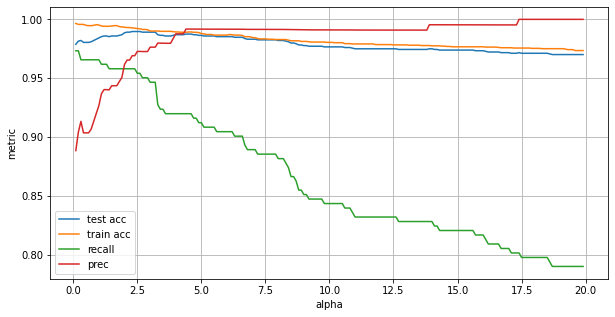

In [115]:
plt.figure(figsize = [10,5])
plt.plot(alpha_range, accuracy)
plt.plot(alpha_range, accuracy_train)
plt.plot(alpha_range, recall)
plt.plot(alpha_range, precision)
plt.legend(['test acc','train acc','recall','prec'])
plt.grid('on')
plt.xlabel('alpha')
plt.ylabel('metric')

<h5>Вывод по графику</h5>

- Из графика видно, что оптимальное значение alpha~3:5. при это частота правильных ответов ~ 0.985


<h4> 6.2 Построим матрицы ошибок для модели с оптимальным выбранным параметром.</h4>

Матрица показывает сколько объектов класса i были распознаны как объекты класса j.

- True Positive (истинно-положительное решение): прогноз совпал с реальностью, результат положительный произошел, как и было предсказано ML-моделью.
- False Positive (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала положительный результат, а на самом деле он отрицательный.
- False Negative (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала отрицательный результат, но на самом деле он положительный.
- True Negative (истинно-отрицательное решение): результат отрицательный, ML-прогноз совпал с реальностью.

<img src="source/Матрица ошибок.png" tyle="text-align: center;line-height: 100%;">

- Accuracy = (TP+TN)/(TP+FP+FN+TN) - процент правильно классифицированных объектов.
- Precision = TP/(TP+FP) - процент правильно классифицированных объектов класса 1 среди всех объектов, которым алгоритм присвоил класс 1.
- Recall = TP/(TP+FN) - процент правильно классифицированных объектов класса 1 среди всех объектов класса 1.

F_1 = 2 * {precision*recall}/{precision+recall}

In [116]:
confusion_matrix = confusion_matrix(y_test, model.predict(X_test))
pd.DataFrame(data  =  confusion_matrix,  columns  =  ['predicted  ham',
'predicted spam'], index = ['actual ham', 'actual spam'])

,predicted ham,predicted spam
actual ham,1577,0
actual spam,52,210


In [117]:
precision = 1595/(1595+0)
print(precision)
recall = 1595/(1595+54)
print(recall)

1.0
0.9672528805336568


<h5>Вывод по матрице ошибок</h5>

- False Positive и False Negative имеют достаточно низкие значения

<h3> 7.Построить ROC-кривую и рассчитать метрику AUC-ROC.</h3>

Результат визуализируем с помощью ROC-кривой(кривая ошибок), а качество - как площадь под этой кривой – AUC. Используют для оценивания качества упорядочивания алгоритмом объектов двух классов.

1. ROC график, показывает зависимость верно классифицируемых объектов положительного класса от ложно положительно классифицируемых объектов негативного класса

- По оси X отложена доля ошибочных положительных классификаций (False Positive Rate)
- По оси Y – доля правильных положительных классификаций(True Positive Rate) или Recall, которую мы хотим максимизировать.

2. AUC равен доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил (объект класса 1 получил оценку выше, чем объект класса 0, т.е вероятность класса 1 быть распознанным как класс 1 выше, чем как класс 0)

- Рассчитаем значения кривой ROC, воспользовавшись библиотекой Scikit-learn:

In [118]:
y_pred_pr = model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics. roc_curve (y_test, y_pred_pr)

- Значение AUC-ROC (значение под кривой) посчитаем, используя библиотеку Scikitlearn

In [119]:
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.9783892500496159


- Построение AUC-ROC кривой

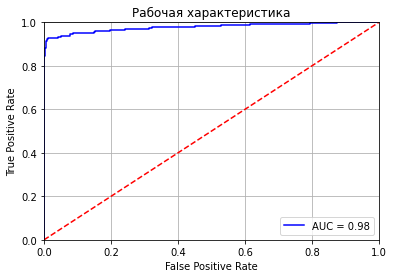

In [120]:
plt.title('Рабочая характеристика')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid('on')
plt.show()

<h5>Вывод по пункту</h5>

- В данном части был реализован наивный байесовский алгоритм с подбором оптимального значения alpha

<h3> 8. Найдём оптимальный параметр регуляризатора С для модели опорных векторов по метрикам precision и accuracy.</h3>

- Задача SVM максимизировать зазор, разделяющий классы. Ширина зазора считается по формуле:

<img src="source/ширина полосы.png" tyle="text-align: center;line-height: 100%;">

- Если выборка линейно не разделима, то нужно ввести штраф С, который штрафует объекты за приближение к границе классов, увеличивая зазор между классами.

<img src="source/Общий случай – линейно неразделимой выборки.png" tyle="text-align: center;line-height: 100%;">

In [121]:
SVC_precision = []
SVC_accuracy = []
SVC_train_accuracy = []
SVC_recall = []
c_range = np.arange(0.1, 3, 0.1)
for c in c_range:
    svc = SVC(C=c)
    svc.fit(X_train, y_train)
    Y_predict = svc.predict(X_test)
    Y_train_predict = svc.predict(X_train)
    SVC_accuracy.append(metrics.accuracy_score(y_test, Y_predict))
    SVC_precision.append(metrics.precision_score(y_test, Y_predict))
    SVC_train_accuracy.append(metrics.accuracy_score(y_train, Y_train_predict))
    SVC_recall.append(metrics.recall_score(y_test, Y_predict))

SVC_matrix = np.matrix(np.c_[c_range, SVC_train_accuracy, SVC_accuracy, SVC_recall, SVC_precision])
SVC_models = pd.DataFrame(data=SVC_matrix, columns=['C', 'train accuracy', 'test accuracy', 'test recall', 'test precision'])
SVC_best_index = SVC_models['test precision'].idxmax()
SVC_best_value = SVC_models['test precision'][SVC_best_index]
print(SVC_best_value)
SVC_best_index = SVC_models[SVC_models['test precision'] == SVC_best_value]['test accuracy'].idxmax()
SVC_model = SVC(C=c_range[SVC_best_index], probability=True)
SVC_model.fit(X_train, y_train)

K:\Project\Python\dynplanner-master\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0


SVC(C=1.4000000000000001, probability=True)

<h4> 8.1 Для SVC. Построим зависимость метрики accuracy на обучающих и тестовых данных от варьируемого параметра. Построить матрицы ошибок для модели с оптимальным выбранным параметром.</h4>

TypeError: 'numpy.ndarray' object is not callable

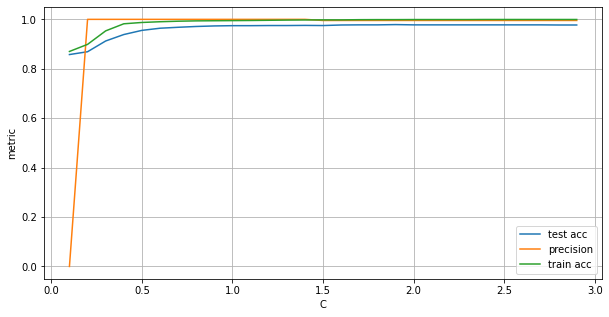

In [122]:
plt.figure(figsize = [10,5])
plt.plot(c_range, SVC_accuracy)
plt.plot(c_range, SVC_precision)
plt.plot(c_range, SVC_train_accuracy)
plt.legend(['test acc','precision','train acc'])
plt.grid('on')
plt.xlabel('C')
plt.ylabel('metric')
SVC_confusion_matrix = confusion_matrix(y_test, SVC_model.predict(X_test))
pd.DataFrame(data  =  SVC_confusion_matrix,  columns  =  ['predicted  ham', 'predicted spam'], index = ['actual ham', 'actual spam'])

<h4> 8.2 Для SVC. Построить ROC-кривую и рассчитать метрику AUC-ROC.</h4>

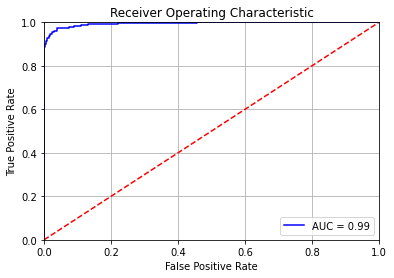

In [124]:
y_pred_pr = SVC_model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics. roc_curve (y_test, y_pred_pr)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid('on')
plt.show()

<h3>Вывод</h3>

 - В работе я ознакомился с метриками accuracy, precision и recall, по ним были выбраны лучшие параметры для MNB и SVC классификаторов, построил матрицы ошибок и AUC-ROC диаграммы.